### dataset - best-artworks-of-all-time(kaggle) for styles &  Pascal VOC (tensorflow) for content images

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ikarus777/best-artworks-of-all-time")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'best-artworks-of-all-time' dataset.
Path to dataset files: /kaggle/input/best-artworks-of-all-time


In [13]:
base="/kaggle/input/best-artworks-of-all-time"

In [14]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import random
from tensorflow import keras

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 20
AUTOTUNE = tf.data.AUTOTUNE

## Dataset

In [15]:
def decode_and_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def extract_image_from_voc(element):
    image = element["image"]
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


style_images=os.listdir(f"{base}/resized/resized")
style_images=[os.path.join(f"{base}/resized/resized/{i}") for i in style_images]

total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

In [16]:
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

In [17]:
train_content_ds = tfds.load("voc", split="train").map(extract_image_from_voc).repeat()
val_content_ds = (tfds.load("voc", split="validation").map(extract_image_from_voc).repeat())
test_content_ds = (tfds.load("voc", split="test").map(extract_image_from_voc, num_parallel_calls=AUTOTUNE).repeat())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.AS64BY_5.0.0/voc-test.tfrecord*...:   0%|          | 0…

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.AS64BY_5.0.0/voc-train.tfrecord*...:   0%|          | …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.AS64BY_5.0.0/voc-validation.tfrecord*...:   0%|       …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/5.0.0. Subsequent calls will reuse this data.


In [18]:
# the size of train_style_ds and train_content_ds is not same so min length will be taken
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Visualisation

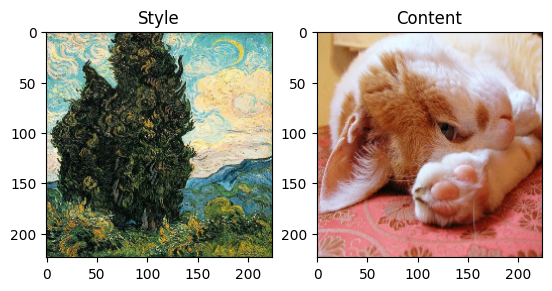

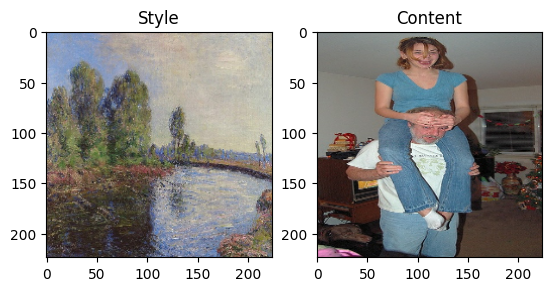

In [19]:
style,content=next(iter(train_ds))[:2]

# style and content will be a batch of 64 images
for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(style[i])
    plt.title("Style")

    plt.subplot(1,2,2)
    plt.imshow(content[i])
    plt.title("Content")
    plt.show()

# Model

## Encoder

In [ ]:
def get_encoder():
    vgg19=keras.applications.VGG19(
        include_top=False,
        input_shape=(*IMAGE_SIZE,3),
        weights="imagenet"
    )

    vgg19.trainable=False
    mid_model=keras.Model(vgg19.input,vgg19.get_layer('block4_conv1').output)

    inputs=tf.keras.layers.Input([*IMAGE_SIZE,3])
    output=mid_model(inputs)
    return tf.keras.Model(inputs,output)

## Adaptive Instance Normalization

In [39]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation

def ada_in(style,content):
    mean_style,std_style=get_mean_std(style)
    mean_content,std_content=get_mean_std(content)

    return std_style*(content-mean_content)/std_content+mean_style

## Decoder

In [ ]:
def get_decoder():
    config={"kernel_size":3,"strides":1,"padding":"same","activation":"relu"}
    return tf.keras.Sequential([
        tf.keras.layers.Input((None,None,512)),
        tf.keras.layers.Conv2D(512,**config),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128,**config),
        tf.keras.layers.Conv2D(128,**config),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(64,**config),
        tf.keras.layers.Conv2D(3,kernel_size=3,strides=1,padding="same",activation="sigmoid"),
    ])

# Loss function

In [ ]:
def get_loss_net():
    vgg19=keras.applications.VGG19(weights="imagenet",include_top=False,input_shape=(*IMAGE_SIZE,3))
    vgg19.trainable=False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = tf.keras.Model(vgg19.input, outputs)

    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")

## Neural Style Transfer

**I am using custom class because by that we can customize what will happen in model.fit**

In [ ]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self,encoder,decoder,loss_net,style_weight,**kwargs):
        super().__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self,optimizer,loss_fn):
        super().compile()
        self.optimizer=optimizer
        self.loss_fn=loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self,inputs):
        style,content=inputs

        loss_style=0.0

        with tf.GradientTape() as tape:
            style_encoded=self.encoder(style)
            content_encoded=self.encoder(content)

            bot=ada_in(style_encoded,content_encoded)

            out=self.decoder(bot)

            style_vgg_features=self.loss_net(style)
            out_vgg_features=self.loss_net(out)

            content_loss=self.loss_fn(bot,out_vgg_features[-1])
            for inp,out in zip(style_vgg_features,out_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(std_inp, std_out)

            loss_style = self.style_weight * loss_style
            total_loss = content_loss + loss_style

        trainable_params=self.decoder.trainable_variables
        gradients=tape.gradient(total_loss,trainable_params)

        self.optimizer.apply_gradients(zip(gradients,trainable_params))

        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(content_loss)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image.
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Compute the AdaIN target feature maps.
        t = ada_in(style=style_encoded, content=content_encoded)

        # Generate the neural style transferred image.
        reconstructed_image = self.decoder(t)

        # Compute the losses.
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

In [ ]:
class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        # style and content are defined in visulaisation section
        style_encoded=self.model.encoder(style)
        content_encoded=self.model.encoder(content)

        bot=ada_in(style_encoded,content_encoded)

        out=self.model.decoder(bot)

        i=0
        plt.subplot(1,3,1)
        plt.imshow(style[i])
        plt.title("Style")

        plt.subplot(1,3,2)
        plt.imshow(content[i])
        plt.title("Content")

        plt.subplot(1,3,3)
        plt.imshow(out[i])
        plt.title("Content")

        plt.axis('off')
        plt.show()

# Training

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 145.6045 - style_loss: 215.3913 - total_loss: 360.9958

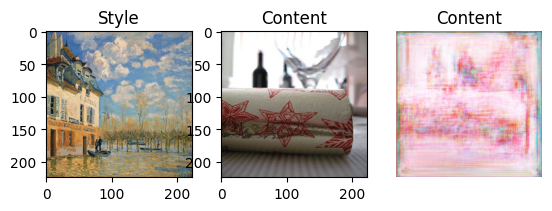

50/50 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - content_loss: 145.4565 - style_loss: 214.8783 - total_loss: 360.3347 - val_content_loss: 125.4855 - val_style_loss: 151.3757 - val_total_loss: 276.8612
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 121.2199 - style_loss: 145.4353 - total_loss: 266.6552

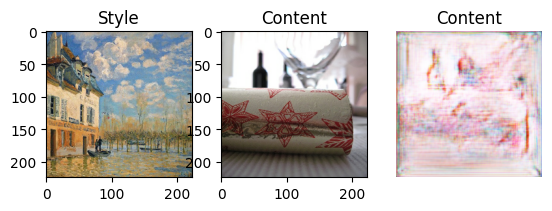

50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - content_loss: 121.1525 - style_loss: 145.2751 - total_loss: 266.4276 - val_content_loss: 110.5774 - val_style_loss: 116.7400 - val_total_loss: 227.3174
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 108.3394 - style_loss: 112.4661 - total_loss: 220.8055

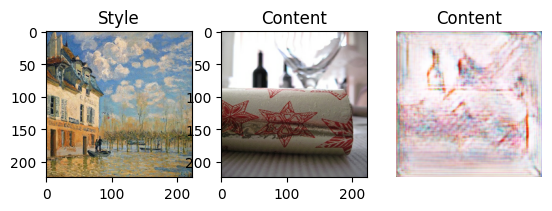

50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - content_loss: 108.3148 - style_loss: 112.4001 - total_loss: 220.7149 - val_content_loss: 101.0976 - val_style_loss: 97.4689 - val_total_loss: 198.5665
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 99.6475 - style_loss: 94.9320 - total_loss: 194.5795

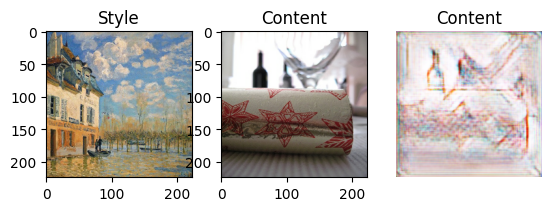

50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - content_loss: 99.6286 - style_loss: 94.8980 - total_loss: 194.5266 - val_content_loss: 95.1152 - val_style_loss: 84.4041 - val_total_loss: 179.5193
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 94.1391 - style_loss: 82.7277 - total_loss: 176.8668

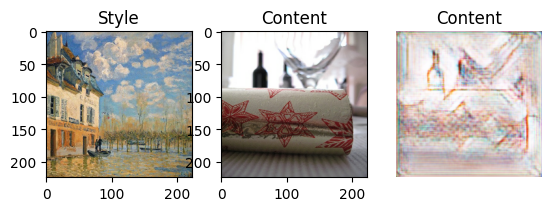

50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - content_loss: 94.1200 - style_loss: 82.7062 - total_loss: 176.8262 - val_content_loss: 89.9821 - val_style_loss: 75.4868 - val_total_loss: 165.4689
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 89.5083 - style_loss: 75.8953 - total_loss: 165.4037

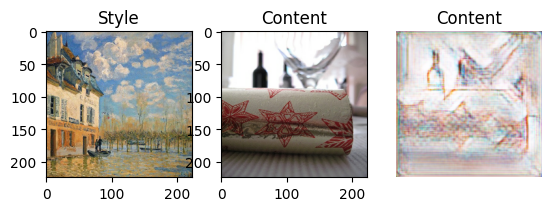

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - content_loss: 89.4906 - style_loss: 75.8768 - total_loss: 165.3674 - val_content_loss: 85.3336 - val_style_loss: 70.9089 - val_total_loss: 156.2425
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 85.1731 - style_loss: 70.1154 - total_loss: 155.2885

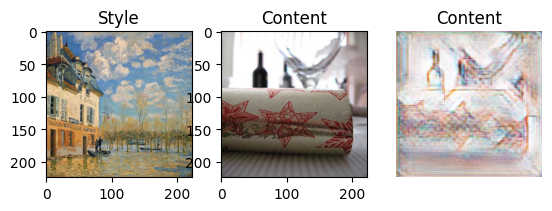

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - content_loss: 85.1619 - style_loss: 70.0917 - total_loss: 155.2536 - val_content_loss: 82.7192 - val_style_loss: 64.8397 - val_total_loss: 147.5590
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 82.5372 - style_loss: 65.1781 - total_loss: 147.7153

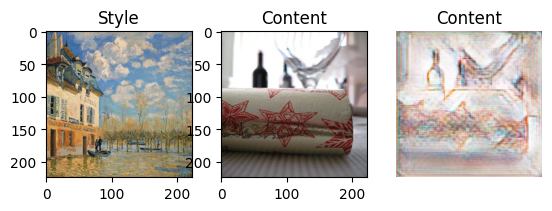

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - content_loss: 82.5208 - style_loss: 65.1581 - total_loss: 147.6789 - val_content_loss: 79.9702 - val_style_loss: 61.2234 - val_total_loss: 141.1936
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 81.3033 - style_loss: 63.9981 - total_loss: 145.3014

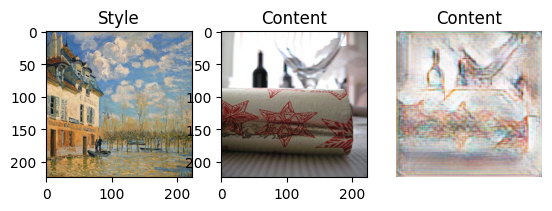

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - content_loss: 81.2759 - style_loss: 63.9494 - total_loss: 145.2253 - val_content_loss: 78.0885 - val_style_loss: 57.6349 - val_total_loss: 135.7234
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - content_loss: 77.9639 - style_loss: 58.8155 - total_loss: 136.7794

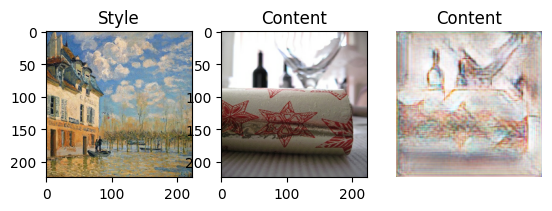

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - content_loss: 77.9503 - style_loss: 58.7869 - total_loss: 136.7372 - val_content_loss: 75.5501 - val_style_loss: 55.0543 - val_total_loss: 130.6044


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model_checkpoint=tf.keras.callbacks.ModelCheckpoint('model.keras',monitor='val_loss',verbose=1,save_best_only=True)

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=4.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

# voc dataset has 2,500 train and val images
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=50,
    validation_data=val_ds,
    validation_steps=50,
    callbacks=[TrainMonitor(),model_checkpoint],
)

In [ ]:
# code for checing ouput
style,content=next(iter(test_ds))[:5]
def check_model(model):
      style_encoded=model.encoder(style)
      content_encoded=model.encoder(content)

      bot=ada_in(style_encoded,content_encoded)

      out=model.decoder(bot)

      for i in range(5):
        plt.subplot(1,3,1)
        plt.imshow(style[i])
        plt.title("Style")

        plt.subplot(1,3,2)
        plt.imshow(content[i])
        plt.title("Content")

        plt.subplot(1,3,3)
        plt.imshow(out[i])
        plt.title("Content")

        plt.axis('off')
        plt.show()

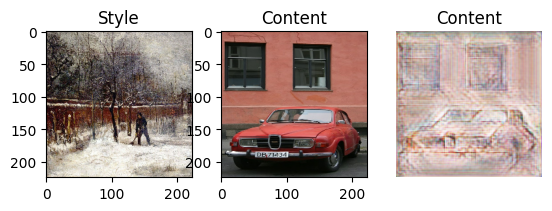

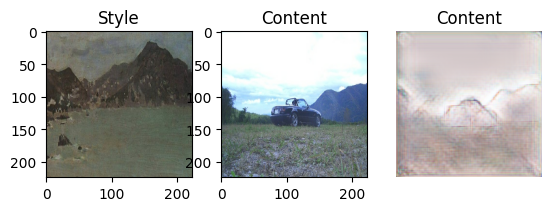

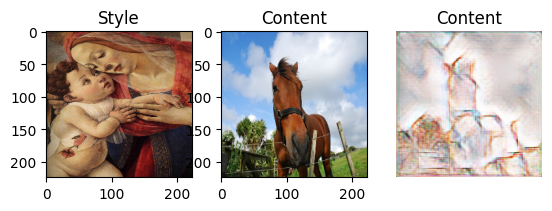

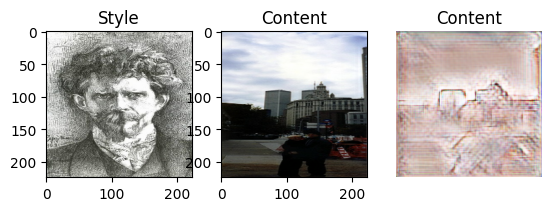

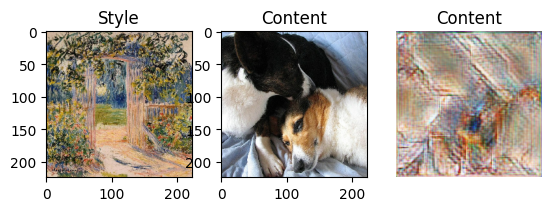

In [ ]:
check_model(model)

In [ ]:
model.save("model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [ ]:
!pip install onnxruntime tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0d

In [ ]:
# converting model onnx
import onnxruntime as ort
import tensorflow as tf
import tf2onnx


spec = (tf.TensorSpec((1, *model.encoder.input_shape[1:]), tf.float32, name="input"),)
tf2onnx.convert.from_keras(model.encoder, input_signature=spec, opset=17,output_path="encoder.onnx")


inp = tf.keras.Input(shape=model.decoder.input_shape[1:], name="input")
out = model.decoder(inp)
wrapped_decoder = tf.keras.Model(inputs=inp, outputs=out)

spec = (tf.TensorSpec((1, *model.decoder.input_shape[1:]), tf.float32, name="input"),)
tf2onnx.convert.from_keras(wrapped_decoder, input_signature=spec, opset=17,output_path="decoder.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7a201c42d6c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7a201c42d6c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Buffered data was truncated after reaching the output size limit.

In [1]:
!pip install mlflow
!pip install mlflow[extras]
!pip install boto3
!pip install awscli
!aws configure

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.3 MB/s eta 0:00:00


In [1]:
# logging model to mlflow

import mlflow

mlflow.set_tracking_uri("http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("NeuralStyleTransform")


<Experiment: artifact_location='s3://pankaj-maulekhi-mlflow/331043977459496726', creation_time=1764084914993, experiment_id='331043977459496726', last_update_time=1764084914993, lifecycle_stage='active', name='NeuralStyleTransform', tags={}>

In [4]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00


In [6]:
import onnx

encoder_path="/content/encoder.onnx"
decoder_path="/content/decoder.onnx"

encoder=onnx.load(encoder_path)
decoder=onnx.load(decoder_path)

with mlflow.start_run():
    mlflow.onnx.log_model(encoder,artifact_path='encoder')
    mlflow.log_param("name","NSTencoder")
    mlflow.log_param("epochs",EPOCHS)
    mlflow.log_param("batch_size",BATCH_SIZE)

with mlflow.start_run():
    mlflow.onnx.log_model(decoder,artifact_path='decoder')
    mlflow.log_param("name","NSTdecoder")
    mlflow.log_param("epochs",EPOCHS)
    mlflow.log_param("batch_size",BATCH_SIZE)

2025/11/25 15:43:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 15:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rebellious-pig-133 at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726/runs/7ded6fa5e95c43bbae26eca6a5c807d9
🧪 View experiment at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726


2025/11/25 15:43:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 15:43:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run serious-dove-629 at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726/runs/972d39c3b7d94ea394bb4bb04403cdbb
🧪 View experiment at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726


In [8]:
run_id="7ded6fa5e95c43bbae26eca6a5c807d9"
encoder_uri = f"runs:/{run_id}/encoder"
encoder_name = "NSTencoder"
model_version = mlflow.register_model(encoder_uri, encoder_name)

Successfully registered model 'NSTencoder'.
2025/11/25 15:46:12 WARNING mlflow.tracking._model_registry.fluent: Run with id 7ded6fa5e95c43bbae26eca6a5c807d9 has no artifacts at artifact path 'encoder', registering model based on models:/m-79c4fb7cf26b4b01ae92cb2124d201fc instead
2025/11/25 15:46:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NSTencoder, version 1
Created version '1' of model 'NSTencoder'.


In [7]:
# registering model
run_id="972d39c3b7d94ea394bb4bb04403cdbb"
decoder_uri = f"runs:/{run_id}/decoder"
decoder_name = "NSTdecoder"
model_version = mlflow.register_model(decoder_uri, decoder_name)

Successfully registered model 'NSTdecoder'.
2025/11/25 15:45:04 WARNING mlflow.tracking._model_registry.fluent: Run with id 972d39c3b7d94ea394bb4bb04403cdbb has no artifacts at artifact path 'decoder', registering model based on models:/m-5a70c81067e24bbfb1c174f19a0ae499 instead
2025/11/25 15:45:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NSTdecoder, version 1
Created version '1' of model 'NSTdecoder'.


In [29]:
encoder_local_path=mlflow.artifacts.download_artifacts(encoder_uri)
decoder_local_path=mlflow.artifacts.download_artifacts(decoder_uri)

In [36]:
# checking model
import onnxruntime as ort
encoder=ort.InferenceSession(
    encoder_local_path+'model.onnx',
    providers=["CUDAExecutionProvider"]   # GPU
)
decoder=ort.InferenceSession(
    decoder_local_path+'model.onnx',
    providers=["CUDAExecutionProvider"]   # GPU
)

In [73]:
import cv2
style=[np.array(Image.open("/download (5).jpeg"))/255.0]
content=[np.array(Image.open("/download.png"))/255.0]

style=[cv2.resize(i,(224,224)) for i in style]
content=[cv2.resize(i,(224,224)) for i in content]

In [74]:
def check_model(encoder,decoder):
      # get input and ouput names
      input_name_encoder = encoder.get_inputs()[0].name
      output_name_encoder = encoder.get_outputs()[0].name

      input_name_decoder = decoder.get_inputs()[0].name
      output_name_decoder = decoder.get_outputs()[0].name

      for i in range(1):
        style_encoded=encoder.run([output_name_encoder],{input_name_encoder:np.expand_dims(np.array(style[i]),axis=0).astype(np.float32)})[0][0]
        content_encoded=encoder.run([output_name_encoder],{input_name_encoder:np.expand_dims(np.array(content[i]),axis=0).astype(np.float32)})[0][0]

        bot=ada_in(style_encoded,content_encoded)

        out=decoder.run([output_name_decoder],{input_name_decoder:np.expand_dims(np.array(bot),axis=0).astype(np.float32)})[0]

        plt.subplot(1,3,1)
        plt.imshow(style[i])
        plt.title("Style")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(content[i])
        plt.title("Content")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(out[0])
        plt.title("Content")

        plt.axis('off')
        plt.show()

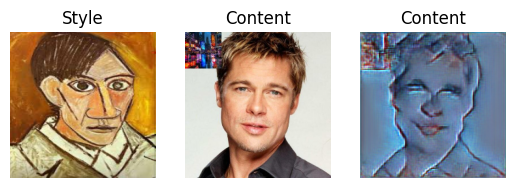

In [75]:
check_model(encoder,decoder)

In [77]:
keras_encoder=tf.keras.models.load_model("/encoder (1).keras")
keras_decoder=tf.keras.models.load_model("/decoder (1).keras")

In [84]:
np.array(style).shape

(1, 224, 224, 3)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_16']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


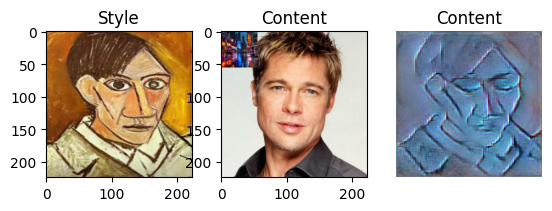

IndexError: list index out of range

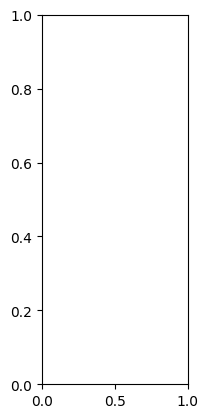

In [86]:
def check_model_keras(keras_encoder,keras_decoder):
      style_encoded=keras_encoder(np.array(style))
      content_encoded=keras_encoder(np.array(content))

      bot=ada_in(style_encoded,content_encoded)

      out=keras_decoder(bot)

      for i in range(5):
        plt.subplot(1,3,1)
        plt.imshow(style[i])
        plt.title("Style")

        plt.subplot(1,3,2)
        plt.imshow(content[i])
        plt.title("Content")

        plt.subplot(1,3,3)
        plt.imshow(out[i])
        plt.title("Content")

        plt.axis('off')
        plt.show()
check_model_keras(keras_encoder,keras_decoder)